In [1]:
import torch

import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
import torch.backends.cudnn as cudnn

In [4]:
class ResidualBlock(nn.Module):
    
    '''
    This residual block is defined by He et al.

    @article{He2015,
	  author = {Kaiming He and Xiangyu Zhang and Shaoqing Ren and Jian Sun},
   	title = {Deep Residual Learning for Image Recognition},
  	journal = {arXiv preprint arXiv:1512.03385},
	  year = {2015}
    }
    '''
    
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
        super(ResidualBlock, self).__init__()
        self.conv_res1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                   kernel_size=kernel_size, padding=padding, stride=stride, bias=False)
        self.conv_res1_bn = nn.BatchNorm2d(num_features=out_channels, momentum=0.9)
        self.conv_res2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                                   kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_res2_bn = nn.BatchNorm2d(num_features=out_channels, momentum=0.9)

        if stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(num_features=out_channels, momentum=0.9))
        else:
            self.downsample = None

        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        residual = x

        out = self.relu(self.conv_res1_bn(self.conv_res1(x)))
        out = self.conv_res2_bn(self.conv_res2(out))

        if self.downsample is not None:
            residual = self.downsample(residual)

        out = self.relu(out)
        out = out + residual
        return out

In [3]:
class Net(nn.Module):

    # This is the 9 layer residual network.

    def __init__(self):
        super(Net, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            ResidualBlock(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            ResidualBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Linear(in_features=1024, out_features=10, bias=True)

    def forward(self, x):
        out = self.conv(x)
        out = out.view(-1, out.shape[1] * out.shape[2] * out.shape[3])
        out = self.fc(out)
        return out

In [5]:
from torchsummary import summary

model = Net().to("cpu")
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
    ResidualBlock-14          [-1, 128,

In [6]:
# Starting with a batch size of 128
batch_size = 128

train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

test_transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

# Using the CIFAR-10 Dataset

training_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_load = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_load = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
for X, Y in train_load:
  print(X.shape)
  print(Y.shape)
  print(X[0])
  break

torch.Size([128, 3, 32, 32])
torch.Size([128])
tensor([[[-1.6731, -1.6149, -1.6537,  ...,  0.1297, -0.3355, -0.3743],
         [-1.6731, -1.6731, -1.6149,  ..., -0.4130, -0.6844, -0.6650],
         [-1.6924, -1.6149, -1.5374,  ..., -0.7620, -0.9170, -1.0527],
         ...,
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],

        [[-1.1989, -1.1399, -1.1792,  ...,  0.6694,  0.1974,  0.1778],
         [-1.1399, -1.1596, -1.0809,  ...,  0.1581, -0.1172, -0.0779],
         [-1.0612, -0.9629, -0.9039,  ..., -0.1369, -0.2942, -0.4122],
         ...,
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],

        [[-2.0458, -1.9873, -2.0263,  ...,  0.0223, -0.4850, -0.5630]

In [9]:
# using Adam optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [10]:
train_acc = []
test_acc = []

In [11]:
def train(data, model, loss_fn, optimizer):
  size = len(data.dataset)
  model.train()
  count = 0

  for batch, (X, y) in enumerate(data):
    X = X.to("cpu")
    y = y.to("cpu")

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()  
    optimizer.step()

    count += (pred.argmax(1) == y).type(torch.float).sum().item()
    if batch % 100 == 0:
      loss = loss.item()
      current = len(X) * batch

      print(f"Data Loss: {loss:>6f} [{current:>5d}/{size:>5d}]")
  
  train_acc.append(count/size)

In [12]:
def test(data, model, loss_fn):
  size = len(data.dataset)
  num_batches = len(data)
  model.eval()
  test_loss = 0
  count = 0
  
  with torch.no_grad():
    for X, y in data:
      X = X.to("cpu")
      y = y.to("cpu")

      pred = model(X)
      test_loss += loss_fn(pred, y).item()

      count += (pred.argmax(1) == y).type(torch.float).sum().item()
 
  test_loss /= num_batches
  count /= size
  test_acc.append(count)
  print(f"Accuracy: {(100*count):>0.01f}%, Average Loss: {test_loss:>7f}\n")

In [14]:
epochs = 100
for i in range(epochs):
  print(f"Epoch {i+1}\n")
  train(train_load, model, loss_fn, optimizer)
  test(test_load, model, loss_fn)
  print("\n---------------------------------------")

Epoch 1

Data Loss: 3.543525 [    0/50000]
Data Loss: 1.476247 [12800/50000]
Data Loss: 1.327366 [25600/50000]
Data Loss: 0.975767 [38400/50000]


KeyboardInterrupt: ignored

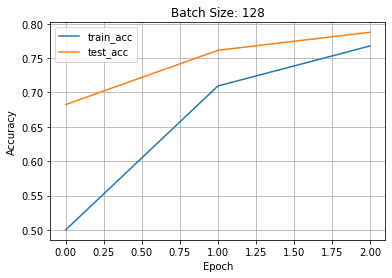

In [16]:
import matplotlib.pyplot as plt
x = [i for i in range(epochs)]
plt.plot(x,train_acc, label = 'train_acc')
plt.plot(x,test_acc, label = 'test_acc')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Batch Size: 128')
plt.grid()
plt.show()